In [1]:
# tensorboard --logdir='runs/'

In [18]:
from datetime import datetime as dt
from itertools import chain

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch.nn.init as init
from tqdm.notebook import tqdm, trange
from torch.utils.tensorboard import SummaryWriter

# Load and preprocess the dataset (assuming you have a CSV file)
df = pd.read_csv("../data/diamonds.csv")
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [2]:
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

In [3]:
def initialize_parameters(module):
    if isinstance(module, (nn.Linear, nn.Conv2d)):
        init.xavier_uniform_(module.weight, gain=1)
        if module.bias is not None:
            init.constant_(module.bias, 0.000)
    elif isinstance(module, nn.Embedding):
        init.uniform_(module.weight, 0.0, 0.5)
    elif isinstance(module, nn.LayerNorm):
        init.normal_(module.weight, mean=0, std=1)
        init.constant_(module.bias, 0.01)

In [4]:
cat_columns = ["cut", "color", "clarity"]
num_columns = ["carat", "depth", "table", "x", "y", "z"]
cat_values = pd.unique(df[cat_columns].values.ravel("K"))
target_column = "price"
tokens = list(
    chain(
        cat_values,
        cat_columns,
        num_columns,
        ["PAD", "[NUMERIC_MASK]", "[MASK]"],
        [target_column],
    )
)
token_dict = {token: i for i, token in enumerate(tokens)}
token_dict

{'Ideal': 0,
 'Premium': 1,
 'Good': 2,
 'Very Good': 3,
 'Fair': 4,
 'E': 5,
 'I': 6,
 'J': 7,
 'H': 8,
 'F': 9,
 'G': 10,
 'D': 11,
 'SI2': 12,
 'SI1': 13,
 'VS1': 14,
 'VS2': 15,
 'VVS2': 16,
 'VVS1': 17,
 'I1': 18,
 'IF': 19,
 'cut': 20,
 'color': 21,
 'clarity': 22,
 'carat': 23,
 'depth': 24,
 'table': 25,
 'x': 26,
 'y': 27,
 'z': 28,
 'PAD': 29,
 '[NUMERIC_MASK]': 30,
 '[MASK]': 31,
 'price': 32}

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
rnd_df = df.sample(frac=1, random_state=42)
scaled_df = rnd_df.loc[:, cat_columns + num_columns + [target_column]]
for col in cat_columns:
    scaled_df[col] = scaled_df[col].map(token_dict)

scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(scaled_df[num_columns].copy())
scaled_df[num_columns] = numeric_scaled

X = scaled_df.drop("price", axis=1)
y = scaled_df["price"]
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Categorical columns
X_train_cat_tensor = torch.tensor(X_train[cat_columns].values, dtype=torch.int32).to(
    device
)
X_test_cat_tensor = torch.tensor(X_test[cat_columns].values, dtype=torch.int32).to(
    device
)
# Numeric columns
X_train_num_tensor = torch.tensor(X_train[num_columns].values, dtype=torch.float32).to(
    device
)
X_test_num_tensor = torch.tensor(X_test[num_columns].values, dtype=torch.float32).to(
    device
)
y_train_tensor = (
    torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

In [7]:
X_train.head(1)

,cut,color,clarity,carat,depth,table,x,y,z
1388,0,10,17,-1.177071,0.244725,-0.652139,-1.570008,-1.518684,-1.514447


In [8]:
X_train_cat_tensor[0], X_train_num_tensor[0], y_train_tensor[0]

(tensor([ 0, 10, 17], dtype=torch.int32),
 tensor([-1.1771,  0.2447, -0.6521, -1.5700, -1.5187, -1.5144]),
 tensor([559.]))

In [9]:
reverse_token_dict = {v: k for k, v in token_dict.items()}

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_head = d_model // n_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)

        # self.initialize_parameters()
        self.apply(initialize_parameters)

    def forward(self, q, k, v, mask=None, input_feed_forward=False):
        batch_size = q.size(0)

        if input_feed_forward:
            q = (
                self.q_linear(q)
                .view(batch_size, -1, self.n_heads, self.d_head)
                .transpose(1, 2)
            )
            k = (
                self.k_linear(k)
                .view(batch_size, -1, self.n_heads, self.d_head)
                .transpose(1, 2)
            )
            v = (
                self.v_linear(v)
                .view(batch_size, -1, self.n_heads, self.d_head)
                .transpose(1, 2)
            )

        attn_output, _ = self.scaled_dot_product_attention(q, k, v, mask)

        attn_output = (
            attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        )
        out = self.out_linear(attn_output)
        return out

    def scaled_dot_product_attention(self, q, k, v, mask=None):
        matmul_qk = torch.matmul(q, k.transpose(-2, -1))
        d_k = q.size(-1)
        scaled_attention_logits = matmul_qk / (d_k**0.5)

        if mask is not None:
            scaled_attention_logits += mask * -1e9

        attention_weights = F.softmax(scaled_attention_logits, dim=-1)
        output = torch.matmul(attention_weights, v)

        return output, attention_weights


class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads):
        super(TransformerEncoderLayer, self).__init__()

        self.multi_head_attention = MultiHeadAttention(d_model, n_heads)

        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model),
        )

        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        # self.initialize_parameters()
        self.apply(initialize_parameters)

    def forward(self, q, k, v, mask=None, input_feed_forward=False):
        attn_output = self.multi_head_attention(q, k, v, mask, input_feed_forward)
        out1 = self.layernorm1(q + attn_output)

        ff_output = self.feed_forward(out1)
        out2 = self.layernorm2(out1 + ff_output)

        return out2


# Parameters
d_model = 64  # Embedding dimension
n_heads = 4  # Number of attention heads
seq_len_q = 10  # Sequence length for the query tensor
seq_len_k = 20  # Sequence length for the key tensor
batch_size = 32  # Batch size

# Random data
q = torch.rand((batch_size, seq_len_q, d_model))
k = torch.rand((batch_size, seq_len_k, d_model))
v = k  # Usually, value and key are the same in many applications

# Model
encoder_layer = TransformerEncoderLayer(d_model, n_heads)

# Forward pass
output = encoder_layer(q, k, v)
print("Output shape:", output.shape)

Output shape: torch.Size([32, 10, 64])


In [11]:
def mask_tensor(tensor, model, probability=0.8):
    if tensor.dtype == torch.float32:
        is_numeric = True
    elif tensor.dtype == torch.int32:
        is_numeric = False
    else:
        raise ValueError(f"Task {tensor.dtype} not supported.")

    tensor = tensor.clone()
    bit_mask = torch.rand(tensor.shape) > probability
    if is_numeric:
        tensor[bit_mask] = torch.tensor(float("-Inf"))
    else:
        tensor[bit_mask] = model.cat_mask_token
    return tensor.to(model.device)

In [12]:
class TabTransformer(nn.Module):
    def __init__(
        self,
        tokens,
        numeric_col_tokens,
        cat_col_tokens,
        token_dict,
        d_model=64,
        n_heads=4,
        device=device,
    ):
        super(TabTransformer, self).__init__()
        self.device = device
        self.d_model = d_model
        self.tokens = tokens
        self.token_dict = token_dict
        self.decoder_dict = {v: k for k, v in token_dict.items()}
        # Masks
        self.cat_mask_token = torch.tensor(self.token_dict["[MASK]"]).to(device)
        self.numeric_mask_token = torch.tensor(self.token_dict["[NUMERIC_MASK]"]).to(
            device
        )

        self.col_tokens = cat_col_tokens + numeric_col_tokens
        self.n_tokens = len(tokens)  # TODO Make this
        # Embedding layers for categorical features
        self.embeddings = nn.Embedding(self.n_tokens, self.d_model).to(device)
        self.n_numeric_cols = len(numeric_col_tokens)
        self.n_cat_cols = len(cat_col_tokens)
        self.n_columns = self.n_numeric_cols + self.n_cat_cols
        # self.numeric_embeddings = NumericEmbedding(d_model=self.d_model)
        self.col_indices = torch.tensor(
            [self.tokens.index(col) for col in self.col_tokens], dtype=torch.long
        ).to(device)
        self.numeric_indices = torch.tensor(
            [self.tokens.index(col) for col in numeric_col_tokens], dtype=torch.long
        ).to(device)
        self.transformer_encoder1 = TransformerEncoderLayer(
            d_model, n_heads=n_heads
        ).to(device)
        self.transformer_encoder2 = TransformerEncoderLayer(
            d_model, n_heads=n_heads
        ).to(device)
        self.regressor = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.ReLU(),
            nn.Linear(d_model * 2, 1),
            # nn.ReLU(),
        ).to(device)

        self.mlm_decoder = nn.Sequential(nn.Linear(d_model, self.n_tokens)).to(
            device
        )  # TODO try making more complex

        self.mnm_decoder = nn.Sequential(
            nn.Linear(
                self.n_columns * self.d_model, self.d_model * 4
            ),  # Try making more complex
            nn.ReLU(),
            nn.Linear(self.d_model * 4, self.n_numeric_cols),
        ).to(device)

        self.flatten_layer = nn.Linear(len(self.col_tokens), 1).to(device)
        self.apply(initialize_parameters)

    def forward(self, num_inputs, cat_inputs, task="regression"):
        # Embed column indices
        repeated_col_indices = self.col_indices.unsqueeze(0).repeat(
            num_inputs.size(0), 1
        )
        col_embeddings = self.embeddings(repeated_col_indices)

        cat_embeddings = self.embeddings(cat_inputs)

        expanded_num_inputs = num_inputs.unsqueeze(2).repeat(1, 1, self.d_model)
        with torch.no_grad():
            repeated_numeric_indices = self.numeric_indices.unsqueeze(0).repeat(
                num_inputs.size(0), 1
            )
            numeric_col_embeddings = self.embeddings(repeated_numeric_indices)

            inf_mask = (expanded_num_inputs == float("-inf")).all(dim=2)

        base_numeric = torch.zeros_like(expanded_num_inputs)

        num_embeddings = (
            numeric_col_embeddings[~inf_mask] * expanded_num_inputs[~inf_mask]
        )
        base_numeric[~inf_mask] = num_embeddings
        base_numeric[inf_mask] = self.embeddings(self.numeric_mask_token)

        query_embeddings = torch.cat([cat_embeddings, base_numeric], dim=1)
        out = self.transformer_encoder1(
            col_embeddings,
            # query_embeddings,
            query_embeddings,
            query_embeddings
            # col_embeddings, query_embeddings, query_embeddings
        )
        out = self.transformer_encoder2(out, out, out)

        if task == "regression":
            out = self.regressor(out)
            out = self.flatten_layer(out.squeeze(-1))

            return out
        elif task == "mlm":
            cat_out = self.mlm_decoder(out)
            # print(f"Out shape: {out.shape}, cat_out shape: {cat_out.shape}")
            numeric_out = out.view(out.size(0), -1)
            # print(f"numeric_out shape: {numeric_out.shape}")
            numeric_out = self.mnm_decoder(numeric_out)
            return cat_out, numeric_out
        else:
            raise ValueError(f"Task {task} not supported.")


no_price_tokens = tokens.copy()
no_price_tokens.remove("price")

numeric_col_tokens = (
    df.head().drop("price", axis=1).select_dtypes(include=np.number).columns.to_list()
)
cat_col_tokens = df.head().select_dtypes(exclude=np.number).columns.to_list()


tab_transformer_model_config = dict(
    tokens=no_price_tokens,
    numeric_col_tokens=numeric_col_tokens,
    cat_col_tokens=cat_col_tokens,
    token_dict=token_dict,
    n_heads=8,
)
model = TabTransformer(**tab_transformer_model_config).to(device)

batch_size = 3
test_num = X_train_num_tensor[0:batch_size, :]
test_num_mask = mask_tensor(test_num, model)
test_cat = X_train_cat_tensor[0:batch_size, :]
test_cat_mask = mask_tensor(test_cat, model)
with torch.no_grad():
    x = model(
        test_num_mask,
        test_cat_mask,
        task="mlm",
    )
x[0].shape, x[1].shape

(torch.Size([3, 9, 32]), torch.Size([3, 6]))

In [13]:
[model.decoder_dict[i.item()] for i in X_train_cat_tensor[0 : 0 + 1, :][0]]

['Ideal', 'G', 'VVS1']

In [14]:
def show_mask_pred(i, model, probability):
    numeric_values = X_train_num_tensor[i : i + 1, :]
    categorical_values = X_train_cat_tensor[i : i + 1, :]
    numeric_masked = mask_tensor(numeric_values, model, probability=probability)
    categorical_masked = mask_tensor(categorical_values, model, probability=probability)
    # Predictions
    with torch.no_grad():
        cat_preds, numeric_preds = model(numeric_masked, categorical_masked, task="mlm")
    # Get the predicted tokens from cat_preds
    cat_preds = cat_preds.argmax(dim=2)
    # Get the words from the tokens
    decoder_dict = model.decoder_dict
    cat_preds = [decoder_dict[i.item()] for i in cat_preds[0]]

    results_dict = {k: cat_preds[i] for i, k in enumerate(model.col_tokens)}
    for i, k in enumerate(model.col_tokens[model.n_cat_cols :]):
        results_dict[k] = numeric_preds[0][i].item()
    # Get the masked values
    categorical_masked = [decoder_dict[i.item()] for i in categorical_masked[0]]
    numeric_masked = numeric_masked[0].tolist()
    masked_values = categorical_masked + numeric_masked
    # zip the masked values with the column names
    masked_values = dict(zip(model.col_tokens, masked_values))
    # Get the original values
    categorical_values = [decoder_dict[i.item()] for i in categorical_values[0]]
    numeric_values = numeric_values[0].tolist()
    original_values = categorical_values + numeric_values
    # zip the original values with the column names
    original_values = dict(zip(model.col_tokens, original_values))
    # print(numeric_masked)
    # print(categorical_masked)
    result_dict = {
        "actual": original_values,
        "masked": masked_values,
        "pred": results_dict,
    }

    return result_dict


show_mask_pred(0, model, 0.8)

{'actual': {'cut': 'Ideal',
  'color': 'G',
  'clarity': 'VVS1',
  'carat': -1.1770710945129395,
  'depth': 0.2447250783443451,
  'table': -0.6521385312080383,
  'x': -1.5700081586837769,
  'y': -1.5186843872070312,
  'z': -1.5144472122192383},
 'masked': {'cut': 'Ideal',
  'color': '[MASK]',
  'clarity': 'VVS1',
  'carat': -1.1770710945129395,
  'depth': 0.2447250783443451,
  'table': -inf,
  'x': -1.5700081586837769,
  'y': -1.5186843872070312,
  'z': -1.5144472122192383},
 'pred': {'cut': 'Very Good',
  'color': 'G',
  'clarity': 'VS1',
  'carat': -2.6973633766174316,
  'depth': 0.8388558626174927,
  'table': -1.164834976196289,
  'x': -0.07436558604240417,
  'y': 0.6589386463165283,
  'z': -2.2548511028289795}}

In [15]:
# Masked Tabualr Modeling
base_model_name = "no_grad10x8h"

model_time = dt.now()
model_time = model_time.strftime("%Y-%m-%dT%H:%M:%S")
model_name = f"{base_model_name}_{model_time}"

In [36]:
# Masked Tabualr Modeling
epochs = 100
batch_size = 1000
lr = 0.001
mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
numeric_loss_scaler = 15
summary_writer = SummaryWriter("runs/" + model_name)

batch_count = 0
model.train()
for epoch in range(epochs):
    for i in range(0, X_train_num_tensor.size(0), batch_size):
        numeric_values = X_train_num_tensor[i : i + batch_size, :]
        categorical_values = X_train_cat_tensor[i : i + batch_size, :]
        numeric_masked = mask_tensor(numeric_values, model, probability=0.8)
        categorical_masked = mask_tensor(categorical_values, model, probability=0.8)
        optimizer.zero_grad()
        cat_preds, numeric_preds = model(numeric_masked, categorical_masked, task="mlm")
        cat_targets = torch.cat(
            (
                categorical_values,
                model.numeric_indices.expand(categorical_values.size(0), -1),
            ),
            dim=1,
        )

        cat_preds = cat_preds.permute(0, 2, 1)  # TODO investigate as possible bug
        # print(
        #     f"cat_preds.shape: {cat_preds.shape}, cat_targets.shape: {cat_targets.shape}"
        # )
        cat_loss = ce_loss(cat_preds, cat_targets)
        numeric_loss = (
            mse_loss(numeric_preds, numeric_values) * numeric_loss_scaler
        )  # Hyper param
        loss = cat_loss + numeric_loss  # TODO Look at scaling
        loss.backward()
        optimizer.step()
        batch_count += 1
        learning_rate = optimizer.param_groups[0]["lr"]
        summary_writer.add_scalar("LossTrain/agg_mask", loss.item(), batch_count)
        summary_writer.add_scalar("LossTrain/mlm_loss", cat_loss.item(), batch_count)
        summary_writer.add_scalar(
            "LossTrain/mnm_loss", numeric_loss.item(), batch_count
        )
        summary_writer.add_scalar("Metrics/mtm_lr", learning_rate, batch_count)
        if batch_count % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item():,.4f}")
            # Test set
            with torch.no_grad():
                numeric_values = X_test_num_tensor
                categorical_values = X_test_cat_tensor
                numeric_masked = mask_tensor(numeric_values, model, probability=0.8)
                categorical_masked = mask_tensor(
                    categorical_values, model, probability=0.8
                )
                optimizer.zero_grad()
                cat_preds, numeric_preds = model(
                    numeric_masked, categorical_masked, task="mlm"
                )
                cat_targets = torch.cat(
                    (
                        categorical_values,
                        model.numeric_indices.expand(categorical_values.size(0), -1),
                    ),
                    dim=1,
                )

                cat_preds = cat_preds.permute(0, 2, 1)
                # print(
                #     f"cat_preds.shape: {cat_preds.shape}, cat_targets.shape: {cat_targets.shape}"
                # )
                cat_loss = ce_loss(cat_preds, cat_targets)
                numeric_loss = (
                    mse_loss(numeric_preds, numeric_values) * numeric_loss_scaler
                )  # Hyper param
                loss = cat_loss + numeric_loss
                summary_writer.add_scalar("LossTest/agg_loss", loss.item(), batch_count)
            summary_writer.add_scalar("LossTest/mlm_loss", cat_loss.item(), batch_count)
            summary_writer.add_scalar(
                "LossTest/mnm_loss", numeric_loss.item(), batch_count
            )

Epoch 3/100 Loss: 2.6014
Epoch 5/100 Loss: 2.4068
Epoch 7/100 Loss: 1.8258
Epoch 10/100 Loss: 1.7211
Epoch 12/100 Loss: 1.5793
Epoch 14/100 Loss: 1.8378
Epoch 16/100 Loss: 1.4947
Epoch 19/100 Loss: 1.2633
Epoch 21/100 Loss: 1.0506
Epoch 23/100 Loss: 0.9923
Epoch 25/100 Loss: 1.2857
Epoch 28/100 Loss: 1.0476
Epoch 30/100 Loss: 1.8471
Epoch 32/100 Loss: 1.2106
Epoch 35/100 Loss: 1.2373
Epoch 37/100 Loss: 1.0830
Epoch 39/100 Loss: 1.0620
Epoch 41/100 Loss: 1.0463
Epoch 44/100 Loss: 0.9681
Epoch 46/100 Loss: 0.8273
Epoch 48/100 Loss: 0.8465
Epoch 50/100 Loss: 0.7984
Epoch 53/100 Loss: 0.9512
Epoch 55/100 Loss: 1.4639
Epoch 57/100 Loss: 0.9741
Epoch 60/100 Loss: 0.8424
Epoch 62/100 Loss: 0.9699
Epoch 64/100 Loss: 1.1518
Epoch 66/100 Loss: 0.9715
Epoch 69/100 Loss: 0.8965
Epoch 71/100 Loss: 0.8300
Epoch 73/100 Loss: 0.8194
Epoch 75/100 Loss: 0.5000
Epoch 78/100 Loss: 0.8621
Epoch 80/100 Loss: 0.8035
Epoch 82/100 Loss: 0.7000
Epoch 85/100 Loss: 0.9032
Epoch 87/100 Loss: 0.7467
Epoch 89/100 Lo

In [48]:
x = show_mask_pred(
    0, model, 0.8
)  # Check for learning... XFKAT # Why is color `GOOD`????? TODO
pd.DataFrame(x).T

,cut,color,clarity,carat,depth,table,x,y,z
actual,Ideal,G,VVS1,-1.177071,0.244725,-0.652139,-1.570008,-1.518684,-1.514447
masked,Ideal,[MASK],[MASK],-inf,-inf,-0.652139,-1.570008,-1.518684,-1.514447
pred,Ideal,G,VS2,-1.209662,0.089562,-0.724785,-1.542991,-1.519413,-1.501559


Finetuning the previous model seems to work but when I pre-train, we run into issues. Let's try again


In [49]:
# Save MTM model
torch.save(model.state_dict(), "./models/latest_mtm.pt")

In [17]:
def fine_tune_model(model, n_rows, model_name, epochs=100, lr=0.01):
    # Regression Model

    batch_size = 1000

    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model_time = dt.now().strftime("%Y-%m-%dT%H:%M:%S")
    model_name = f"{model_name}_{n_rows}_{model_time}"

    summary_writer = SummaryWriter("runs/" + model_name)
    if n_rows is None:
        n_rows = X_train_num_tensor.size(0)
    if n_rows > X_train_num_tensor.size(0):
        raise ValueError(
            f"n_rows ({n_rows}) must be less than or equal to {X_train_num_tensor.size(0)}"
        )

    train_set_size = n_rows  # X_train_num_tensor.size(0)
    batch_count = 0
    model.train()
    for epoch in trange(epochs):
        for i in range(0, train_set_size, batch_size):
            num_inputs = X_train_num_tensor[i : i + batch_size, :]
            cat_inputs = X_train_cat_tensor[i : i + batch_size, :]
            optimizer.zero_grad()
            y_pred = model(num_inputs, cat_inputs)
            loss = loss_fn(y_pred, y_train_tensor[i : i + batch_size, :])
            loss.backward()
            optimizer.step()
            batch_count += 1
            learning_rate = optimizer.param_groups[0]["lr"]
            summary_writer.add_scalar(
                "LossTrain/regression_loss", loss.item(), batch_count
            )
            summary_writer.add_scalar(
                "Metrics/regression_lr", learning_rate, batch_count
            )

        # Test set
        with torch.no_grad():
            y_pred = model(X_test_num_tensor, X_test_cat_tensor)
            loss_test = loss_fn(y_pred, y_test_tensor)
            summary_writer.add_scalar(
                "LossTest/regression_loss", loss_test.item(), batch_count
            )
            print(f"Epoch {epoch+1}/{epochs} Test Loss: {loss_test.item():,.2f}")
            # print(
            #     f"Epoch {epoch+1}/{epochs} Loss: {loss.item():,.2f} "
            #     + f"Test loss: {loss_test.item():,.2f}"
            # )
    return {"n_rows": n_rows, "test_loss": loss_test.item()}


model = TabTransformer(**tab_transformer_model_config).to(device)
model.load_state_dict(torch.load("./models/latest_mtm.pt"))
fine_tune_model(model=model, n_rows=100, model_name="model", epochs=100, lr=0.01)

Epoch 1/500 Test Loss: 31,068,604.00
Epoch 2/500 Test Loss: 30,947,444.00
Epoch 3/500 Test Loss: 30,781,222.00
Epoch 4/500 Test Loss: 30,600,790.00
Epoch 5/500 Test Loss: 30,413,112.00
Epoch 6/500 Test Loss: 30,200,550.00
Epoch 7/500 Test Loss: 29,949,886.00
Epoch 8/500 Test Loss: 29,655,768.00
Epoch 9/500 Test Loss: 29,316,668.00
Epoch 10/500 Test Loss: 28,933,258.00
Epoch 11/500 Test Loss: 28,501,498.00
Epoch 12/500 Test Loss: 28,015,534.00
Epoch 13/500 Test Loss: 27,470,594.00
Epoch 14/500 Test Loss: 26,865,714.00
Epoch 15/500 Test Loss: 26,201,934.00
Epoch 16/500 Test Loss: 25,479,440.00
Epoch 17/500 Test Loss: 24,698,682.00
Epoch 18/500 Test Loss: 23,862,788.00
Epoch 19/500 Test Loss: 22,978,056.00
Epoch 20/500 Test Loss: 22,053,906.00
Epoch 21/500 Test Loss: 21,103,454.00
Epoch 22/500 Test Loss: 20,143,922.00
Epoch 23/500 Test Loss: 19,197,380.00
Epoch 24/500 Test Loss: 18,291,930.00
Epoch 25/500 Test Loss: 17,462,276.00
Epoch 26/500 Test Loss: 16,749,183.00
Epoch 27/500 Test Los

{'n_rows': 100, 'test_loss': 762844.1875}

In [ ]:
# Regression Model

epochs = 100
batch_size = 1000
lr = 0.001
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model_time = dt.now()
model_time = model_time.strftime("%Y-%m-%dT%H:%M:%S")
model_name = f"FULL{model_time}"

summary_writer = SummaryWriter("runs/" + model_name)

small_test = True
train_set_size = X_train_num_tensor.size(0)
batch_count = 0
model.train()
for epoch in range(epochs):
    for i in range(0, train_set_size, batch_size):
        num_inputs = X_train_num_tensor[i : i + batch_size, :]
        cat_inputs = X_train_cat_tensor[i : i + batch_size, :]
        optimizer.zero_grad()
        y_pred = model(num_inputs, cat_inputs)
        loss = loss_fn(y_pred, y_train_tensor[i : i + batch_size, :])
        loss.backward()
        optimizer.step()
        batch_count += 1
        learning_rate = optimizer.param_groups[0]["lr"]
        summary_writer.add_scalar("LossTrain/regression_loss", loss.item(), batch_count)
        summary_writer.add_scalar("Metrics/regression_lr", learning_rate, batch_count)

    # Test set
    with torch.no_grad():
        y_pred = model(X_test_num_tensor, X_test_cat_tensor)
        loss_test = loss_fn(y_pred, y_test_tensor)
        summary_writer.add_scalar("LossTest/regression_loss", loss.item(), batch_count)
        print(
            f"Epoch {epoch+1}/{epochs} Loss: {loss.item():,.2f} "
            + f"Test loss: {loss_test.item():,.2f}"
        )

In [23]:
with torch.no_grad():
    y_pred = model(X_test_num_tensor, X_test_cat_tensor)
    loss = loss_fn(y_pred, y_test_tensor)
    print(f"Test loss: {loss.item():,.2f}")

Test loss: 541,435.44


In [73]:
(673_383.84 - loss.item()) / (673_383.84)

0.266401221478674

In [56]:
for i in range(10):
    print(
        f"Predicted: {y_pred[i].item():,.2f} Actual: {y_test_tensor[i].item():,.2f}",
        f"Diff: {y_pred[i].item() - y_test_tensor[i].item():,.2f}",
    )

Predicted: 1,471.62 Actual: 1,754.00 Diff: -282.38
Predicted: 6,565.45 Actual: 6,927.00 Diff: -361.55
Predicted: 955.20 Actual: 1,264.00 Diff: -308.80
Predicted: 2,384.49 Actual: 2,278.00 Diff: 106.49
Predicted: 3,408.32 Actual: 2,858.00 Diff: 550.32
Predicted: 2,491.25 Actual: 8,133.00 Diff: -5,641.75
Predicted: 759.22 Actual: 840.00 Diff: -80.78
Predicted: 16,254.14 Actual: 16,792.00 Diff: -537.86
Predicted: 779.46 Actual: 815.00 Diff: -35.54
Predicted: 816.92 Actual: 734.00 Diff: 82.92


In [22]:
1 / 0

ZeroDivisionError: division by zero

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

# Load and preprocess the dataset (assuming you have a CSV file)
data = pd.read_csv("../data/diamonds.csv")

# Separate features and target variable
X = data.drop("price", axis=1)
y = data["price"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocess categorical features
cat_columns = ["cut", "color", "clarity"]
X_train_cat = X_train[cat_columns]
X_test_cat = X_test[cat_columns]

label_encoders = {}
for col in cat_columns:
    le = LabelEncoder()
    X_train_cat[col] = le.fit_transform(X_train_cat.loc[:, col])
    X_test_cat[col] = le.transform(X_test_cat.loc[:, col])
    label_encoders[col] = le

# Preprocess numeric features
num_columns = ["carat", "depth", "table", "x", "y", "z"]
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_columns])
X_test_num = scaler.transform(X_test[num_columns])


# Convert data to PyTorch tensors
X_train_cat_tensor = torch.tensor(X_train_cat.values, dtype=torch.int64)
X_train_num_tensor = torch.tensor(X_train_num, dtype=torch.float32)
X_test_cat_tensor = torch.tensor(X_test_cat.values, dtype=torch.int64)
X_test_num_tensor = torch.tensor(X_test_num, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)


# Define the neural network model
class DiamondPricePredictor(nn.Module):
    def __init__(self, num_input_dim, cat_embedding_sizes, hidden_dim):
        super(DiamondPricePredictor, self).__init__()

        # Embedding layers for categorical features
        self.embeddings = nn.ModuleList(
            [
                nn.Embedding(num_classes, emb_size)
                for num_classes, emb_size in cat_embedding_sizes
            ]
        )

        total_emb_dim = sum(emb_size for _, emb_size in cat_embedding_sizes)
        self.predictor = nn.Sequential(
            nn.Linear(num_input_dim + total_emb_dim, hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
        # self.fc1 = nn.Linear(num_input_dim + total_emb_dim, hidden_dim)
        # self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, num_inputs, cat_inputs):
        embeddings = [
            embedding(cat_inputs[:, i]) for i, embedding in enumerate(self.embeddings)
        ]
        cat_features = torch.cat(embeddings, dim=1)
        x = torch.cat([num_inputs, cat_features], dim=1)

        x = self.predictor(x)
        return x


# Initialize the model
num_input_dim = X_train_num.shape[1]
cat_embedding_sizes = [
    (len(le.classes_), min(50, (len(le.classes_) + 1) // 2))
    for le in label_encoders.values()
]
hidden_dim = 64
simple_model = DiamondPricePredictor(num_input_dim, cat_embedding_sizes, hidden_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(simple_model.parameters(), lr=0.01)

# Training loop
epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = simple_model(
        X_train_num_tensor,  # [0:batch_size],
        X_train_cat_tensor,  # [0:batch_size],
    )  # Pass numeric and categorical tensors separately
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():,.2f}")

print("Training complete!")
# Evaluate the model

Epoch 1/2000, Loss: 31,439,220.00


/var/folders/rs/qflxwtyx6kvfj8jcqx5zm5hr0000gn/T/ipykernel_12919/1167013342.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_cat[col] = le.fit_transform(X_train_cat.loc[:, col])
/var/folders/rs/qflxwtyx6kvfj8jcqx5zm5hr0000gn/T/ipykernel_12919/1167013342.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_cat[col] = le.transform(X_test_cat.loc[:, col])
/var/folders/rs/qflxwtyx6kvfj8jcqx5zm5hr0000gn/T/ipykernel_12919/1167013342.py:29: SettingWithCopyWarning: 
A value is trying to be set on

Epoch 201/2000, Loss: 669,738.62
Epoch 401/2000, Loss: 439,377.12


KeyboardInterrupt: 

In [ ]:
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_num_tensor, X_test_cat_tensor)
    mse = mean_squared_error(y_test_tensor, test_predictions)
    print(f"Mean Squared Error on Test Data: {mse:,.2f}")  # 735,349.69

Mean Squared Error on Test Data: 30,910,758.00


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(
    f"Number of Params in Tabular Model:{count_parameters(model):,}",
    f"Number of Params in Simple Model:{count_parameters(simple_model):,}",
)

Number of Params in Tabular Model:261,809 Number of Params in Simple Model:45,900


In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Load the diamonds dataset
diamonds_data = pd.read_csv("../data/diamonds.csv")

# Encode categorical features using LabelEncoder
label_encoders = {}
categorical_features = ["cut", "color", "clarity"]
for feature in categorical_features:
    le = LabelEncoder()
    diamonds_data[feature] = le.fit_transform(diamonds_data[feature])
    label_encoders[feature] = le

# Split the dataset into features (X) and target (y)
X = diamonds_data.drop("price", axis=1)
y = diamonds_data["price"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train the XGBoost regressor
xgb_regressor = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_regressor.fit(
    X_train[0:batch_size],
    y_train[0:batch_size],
)

# Predict on the test set
y_pred = xgb_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:,.2f}")

# You can also access feature importance scores
# feature_importances = xgb_regressor.feature_importances_
# print("Feature Importance:")
# for feature, importance in zip(X.columns, feature_importances):
#     print(f"{feature}: {importance:.4f}")

Mean Squared Error: 673,383.84


In [62]:
def xgb_tester(train_set_size):
    xgb_regressor = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_regressor.fit(
        X_train[0:train_set_size],
        y_train[0:train_set_size],
    )

    y_pred = xgb_regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse


mses = {}
for i in range(1000, 44000, 1000):
    mse = xgb_tester(i)
    mses[i] = mse

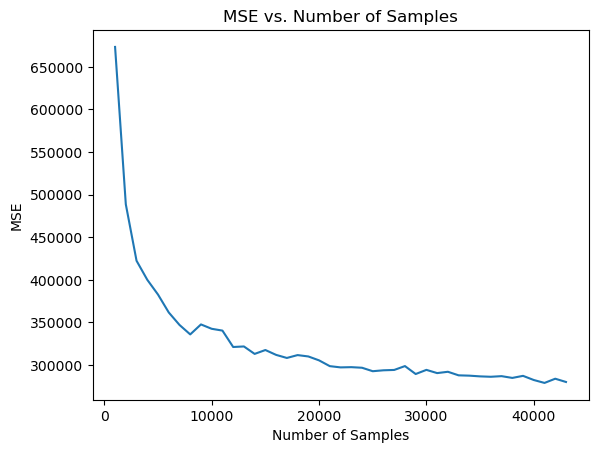

In [63]:
import matplotlib.pyplot as plt

# Define the dictionary

# Extract the x and y values from the dictionary
x = list(mses.keys())
y = list(mses.values())

# Create a line plot
plt.plot(x, y)

# Add labels and title
plt.xlabel("Number of Samples")
plt.ylabel("MSE")
plt.title("MSE vs. Number of Samples")

# Show the plot
plt.show()

In [65]:
mses

{1000: 673383.8424745769,
 2000: 488658.2629755395,
 3000: 422387.5912084758,
 4000: 400050.20091023814,
 5000: 382692.46425053675,
 6000: 361696.7359423982,
 7000: 347060.8782991371,
 8000: 335927.7780321159,
 9000: 347646.5456652291,
 10000: 342515.203624628,
 11000: 340405.0255080609,
 12000: 321155.15150586085,
 13000: 321786.4186075241,
 14000: 313044.210626029,
 15000: 317607.4170493895,
 16000: 311893.83646389376,
 17000: 308288.66516828345,
 18000: 311645.89919669274,
 19000: 310051.99311877246,
 20000: 305460.9976913605,
 21000: 298675.61869602784,
 22000: 297213.8142488428,
 23000: 297484.2940444159,
 24000: 296799.75403719075,
 25000: 292727.36708097695,
 26000: 293802.83884854906,
 27000: 294219.3616975973,
 28000: 298747.65880516416,
 29000: 289433.0572588045,
 30000: 294304.356059232,
 31000: 290512.14676491043,
 32000: 292071.330825601,
 33000: 287885.04899814393,
 34000: 287511.3364757178,
 35000: 286662.58478553843,
 36000: 286205.7910110461,
 37000: 286931.27869797597

In [30]:
X_train.shape

(43152, 9)